Solve small-scale quantum optimization problems

Course URL
https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm

Part 1: Small-scale QAOA

Solve the Maximum-Cut (Max-Cut) problem for a small graph and then learn how to execute it at utility scale.  

The goal of this problem is to partition the nodes of a graph into two sets such that the number of edges traversed by this cut is maximized.

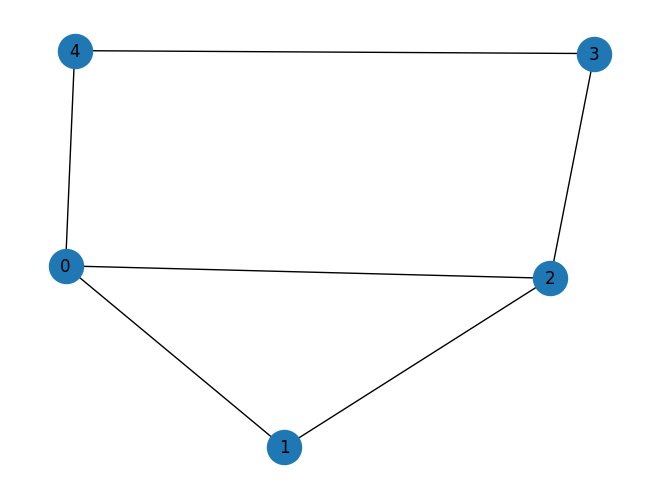

In [2]:
# Initialize the problem by creating a graph with n = 5 nodes.
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np

n = 5

graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0)]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

**Step 1: Map classical inputs to a quantum problem**

First map the classical problem into quantum circuits and operators. The follow are the three main steps to take:

1. Use math to represent this problem in Quadratic Unconstrained Binary Optimization (QUBO), aka represent it in quantum math readable. 

2. Rewrite the problem as a Hamiltonian for ground state which minimizes the cost function. 

    Cost function: is the value or "cost" associated with a particular cut of the graph.

3. Create a quantum circuit which will prepare the ground state of this Hamiltonian via a process similar to quantum annealing. 

In QAOA methodology, an operator (Hamiltonian) represents the cost function and parametrized circuit (Ansatz) that represents quantum states with candidate solutions to the problem. 

    Parametrized circuit (Ansatz): apply a seqsuence of quantum gates that depend on a set of parameters. 

<p style="font-size:20px;">Optimization problem using Hamiltonian. The goal is to use a quantum computer to find the most stable state of a special function (in this case the Hamiltonian). </p>

**Problem in QUBO notation:**
 
min x^T Qx

x∈{0,1}^n

Q is a n x n matrix of real numbers
n corresponds to the number of nodes in the graph
x is the vector of binary variables introduced above
x^T is the transpose of the vector x


**Convert Problem from QUBO notation to Hamiltonian**
  
Notes: Optimization_problem_hamiltonian_pic.pdf

In [3]:
from qiskit.quantum_info import SparsePauliOp
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list


max_cut_paulis = build_max_cut_paulis(graph)

cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


**Convert Problem from Hamiltonian to Quantum circuit**

Notes: Hamiltonian_to_circuit_pic.pdf

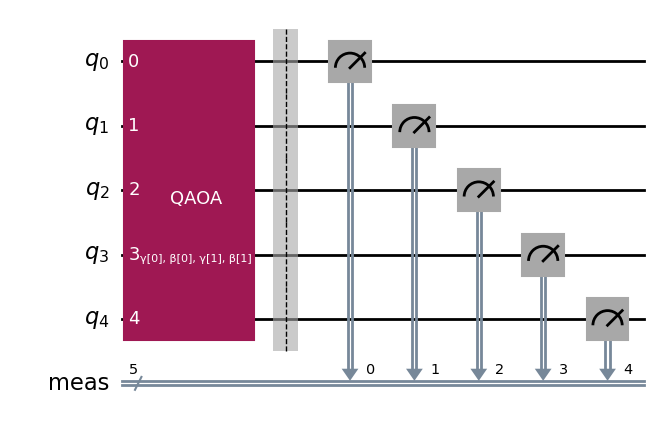

In [4]:
# try an example with one QAOA layer that contains two parameters y1 and B1

from qiskit.circuit.library import QAOAAnsatz

circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all()

circuit.draw('mpl')

In [5]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])

** Step 2. Optimize Circuits for Quantum hardware execution **

Before a circuit can run on QPU, the circuit needs to undergo a series of operations that make up the transpilation or circuit optimization step of the pattern. 

Qiskit library offers a series of transpilation passes. 

Transpilation involves several steps

1. **Initial mapping** of the qubits in the circuit (such as decision variables) to physical qubits on the device. 
2. **Unrolling** of the instructions in the quantum circuit to the hardware-native instructions that the backend understands. 
3. **Routing** of any qubits in the circuit that interact to physical qubits that are adjacent with one another. 
4. **Error suppression** by adding single-qubit gates to suppress noise with dynamical decoupling. 


The following code transforms and optimizes the abstract circuit into a format that is ready for execution on one of devices accessible through the cloud using the Qiskit IBM Runtime service.

<IBMBackend('ibm_kyiv')>


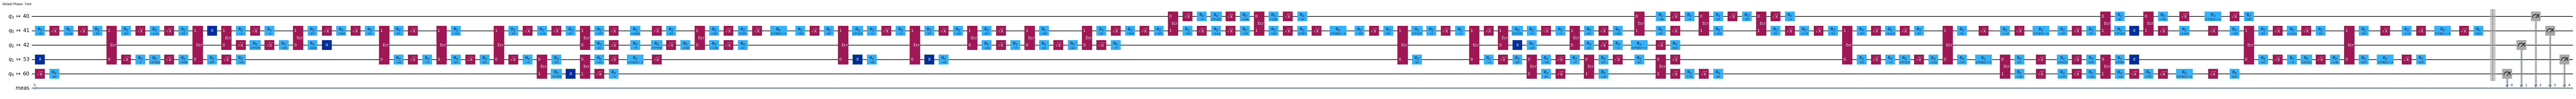

In [6]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.least_busy(min_num_qubits=127)
print(backend)

# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend)

candidate_circuit = pm.run(circuit)
candidate_circuit.draw('mpl', fold=False, idle_wires=False)

**Step 3. Execute using Qiskit primitives**

You are running an iterative optimization loop

Steps
1. Define the initial parameters
2. Instantiate a new session containing the optimization loop and the primitive used to sample the circuit. 
3. Once an optimal set of parameters is found, execute the circuit a final time to obtain a final distribution which will be used in the post-process step.

**Define circuit with initial parameters**

In [7]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta, initial_gamma, initial_beta]

**Define backend and execution primitive**

Use either the two primitives (sampler or estimator) depending on the type of measurement. 

Since the measurement of the cost function is simply the expectation value of braket Hc you would you estimator

**Run**

In [8]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)


    return cost

In [ ]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize


objective_func_vals = [] # Global variable
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-2,
    )
    print(result)

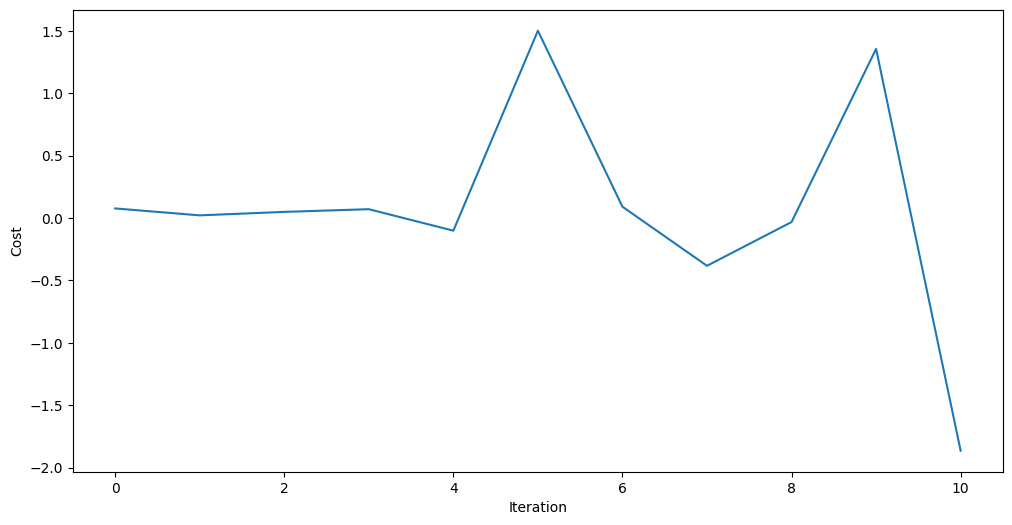

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

Once you find the optimal parameters for the circuit, you can assign these parameters and sample the final distribution. This is where you use the Sampler primitive.

In [ ]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

**Step 4. Post-process, return result in classical format**

Interpret the sampling output to return a solution for your orginal problem. 

We are interested in the bitstring with the highest probability for the optimal cut. 

In [ ]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()

Visual the best cut

In [ ]:
# auxiliary function to plot graphs
def plot_result(G, x):
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    pos, default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(G, node_color=colors, node_size=100, alpha=0.8, pos=pos)


plot_result(graph, most_likely_bitstring)

Calculate the value of the cut

In [ ]:
from typing import Sequence
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "The length of x must coincide with the number of nodes in the graph."
    return sum(x[u] * (1 - x[v]) + x[v] * (1 - x[u]) for u, v in list(graph.edge_list()))


cut_value= evaluate_sample(most_likely_bitstring, graph)
print('The value of the cut is:', cut_value)